In [ ]:
### MY NUMERICAL APPROACH TO THE SILICON DETECTOR SIMULATION. NUMERICAL METHOD ULTIMATELY PROVED TO BE THE BEST ###

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import scipy as sp
import cProfile
from numba import guvectorize

In [2]:
### Global Constants ###
K = 1.38e-23         # Boltzmann constant (J/K)
T = 300             # temperature (K)
CHARGE = 1.6e-19    # electron charge (C)
BIAS = 120           # operational volatge (V)
PAIR_CREATION_E = 3.62e-3  # pair creation energy in Si (keV)
MU_E = 1350         #cm^2/Vs
MU_H = 480          #cm^2/Vs
xv_um = 1000         #um
xi_um = 20          #um

xi = xi_um * 1e-4   #cm
xg = 0              #cm          
xv = xv_um * 1e-4   #cm

In [ ]:
### DEFUNCT FUNCS ### 
# Kept in case need to revive old methods


# old method, not used now
def generate_current_old(timeline, timestep, xv, xg, xinit, type):
    i_of_t = []
    if type == 'electron':
        step_direction = 1
    elif type == 'hole':
        step_direction = -1

    x_now = xinit
    while xg <= x_now <= xv:
        i_of_t.append(instant_i(x_now, type))
        velocity = get_drift_speed(x_now, type)
        x_now += step_direction * velocity * timestep

    length = len(i_of_t)
    total_time = length * timestep
    time_len = len(timeline)
    i_of_t = np.array(i_of_t)
    fill = np.full(time_len - length, 0)
    i_of_t = np.concatenate((np.array(i_of_t), fill))
    return i_of_t, total_time

# old method, not used now
def generate_charge_old(timeline, timestep, xv, xg, xinit, type):
    q_of_t = [0]
    if type == 'electron':
        step_direction = 1
    elif type == 'hole':
        step_direction = -1

    x_now = xinit
    while xg <= x_now <= xv:
        w_pot_i = get_potential(x_now, bias = 1)
        x_now += step_direction * get_drift_speed(x_now, type) * timestep
        w_pot_f = get_potential(x_now, bias = 1)
        del_Q = abs(w_pot_f - w_pot_i) * CHARGE
        q_of_t.append(q_of_t[-1] + del_Q)
    
    length = len(q_of_t)
    total_time = length * timestep
    time_len = len(timeline)
    #print(length, time_len, time_len - length)
    fill = np.full(time_len - length, q_of_t[-1])
    q_of_t = np.concatenate((np.array(q_of_t), fill))
    return q_of_t, total_time


# old method, not used now
def single_pair_sim_old(x_init, time, timestep, xv, xg):
    sum_current = np.zeros(time.shape)
    sum_charge = np.zeros(time.shape)
    current_v_timee, total_time_e = generate_current_old(time, timestep, xv, xg, x_init, 'electron')
    current_v_timeh, total_time_h = generate_current_old(time, timestep, xv, xg, x_init, 'hole')
    charge_v_timee, total_time_e2 = generate_charge_old(time, timestep, xv, xg, x_init, 'electron')
    charge_v_timeh, total_time_h2 = generate_charge_old(time, timestep, xv, xg, x_init, 'hole')
    sum_current += current_v_timee + current_v_timeh
    sum_charge += charge_v_timee + charge_v_timeh
    return sum_current, sum_charge

# old method, not used now
def simulate_event_old(x_inits, time, timestep, xv, xg):
    total_current = np.zeros(time.shape)
    total_charge = np.zeros(time.shape)
    for x_init in x_inits:
        sum_current, sum_charge = single_pair_sim_old(x_init, time, timestep, xv, xg)
        total_current += sum_current
        total_charge += sum_charge
    return total_current, total_charge

# old method, not used now
def simulate_event_parallel_old(x_inits, time, timestep, xv, xg):
    iterable = []
    for x_init in x_inits:
        iterable.append((x_init, time, timestep, xv, xg))
    cores = mp.cpu_count() - 2
    chunk = int(len(iterable) / cores)

    with mp.Pool(processes=cores) as p:
        result = p.starmap(single_pair_sim_old, iterable, chunksize=chunk)
    
    total_current = np.zeros(time.shape)
    total_charge = np.zeros(time.shape)
    
    for event in result:
        total_current += event[0]
        total_charge += event[1]

    return total_current, total_charge


# no longer used in favor of integration method
def generate_charge(timeline, timestep, x_init, electron_array, hole_array, type):
    if type == 'electron':
        x_index = np.searchsorted(electron_array[:,0], x_init)
        potential = electron_array[x_index:,2]
    elif type == 'hole':
        hole_sort = np.argsort(hole_array[:,0])
        x_index = np.searchsorted(hole_array[:,0], x_init, sorter=hole_sort)
        potential = hole_array[-(x_index+1):,2]

    dqs = np.absolute(potential[:-1] - potential[1:]) * CHARGE
    q_v_t = np.cumsum(dqs)
    q_v_t = np.insert(q_v_t, 0, 0)
    length = q_v_t.size
    total_time = length * timestep
    time_len = timeline.size
    fill = np.full(time_len - length, q_v_t[-1])
    q_v_t = np.concatenate((q_v_t, fill),0)
    return q_v_t, total_time


# no longer used
def single_pair_sim(x_init, time, timestep, electron_array, hole_array, diff=False, convolve=False):
    if diff:
        current_v_timee, total_time_e, brute_extend_len_e = generate_current_w_diffusion(time, timestep, x_init, electron_array, hole_array, 'electron')
        current_v_timeh, total_time_h, brute_extend_len_h = generate_current_w_diffusion(time, timestep, x_init, electron_array, hole_array, 'hole')
    else:
        current_v_timee, total_time_e = generate_current(time, timestep, x_init, electron_array, hole_array, 'electron')
        current_v_timeh, total_time_h = generate_current(time, timestep, x_init, electron_array, hole_array, 'hole')
    
    sum_current = current_v_timee + current_v_timeh
    #sum_charge = charge_v_timee + charge_v_timeh
    return sum_current#, sum_charge


# no longer used
def simulate_event_parallel(x_inits, time, timestep, electron_array, hole_array):
    iterable = []
    for x_init in x_inits:
        iterable.append((x_init, time, timestep, electron_array, hole_array))
    cores = mp.cpu_count() - 2
    chunk = int(len(iterable) / cores)

    with mp.Pool(processes=cores) as p:
        result = p.starmap(single_pair_sim, iterable, chunksize=chunk)
    
    total_current = np.zeros(time.shape)
    total_charge = np.zeros(time.shape)
    
    for event in result:
        total_current += event[0]
        total_charge += event[1]

    return total_current, total_charge


#   unused
def gauss_blur(array, sigma, timestep):
    std_dev = sigma / timestep
    return sp.ndimage.gaussian_filter1d(array, std_dev)

In [ ]:
### ALL ACTUALLY USED FUNCTIONS ###

def get_potential(x, bias = BIAS):
    return bias * x / (xv - xg)


#  currently constant so no x dependence
def get_electric_field(x, bias = BIAS):
    return bias / (xv - xg)


def get_drift_speed(x_pos, type):
    if type == 'electron':
        mu = MU_E
    elif type == 'hole':
        mu = MU_H
    return mu * get_electric_field(x_pos)


def instant_i(x_pos, type):
    return CHARGE * get_drift_speed(x_pos, type) * get_electric_field(x_pos, bias=1)  # Shockley-Ramo theorem


def calc_sigma(sampx, del_x, type):
    E_field = get_electric_field(sampx)
    sig_x = np.sqrt((2*K*T*del_x)/(CHARGE*E_field))         # standard deviation of spatial diffusion in cm -- units work I swear u gotta beleive me I swear
    speed = get_drift_speed(sampx, type)                    # stdev of collection time diffusion in s (i think)
    sig_t = sig_x / speed          
    return sig_t   


def integrate_current(current, time):
    result = sp.integrate.cumulative_trapezoid(current, time)
    result = np.insert(result, 0, 0)
    return result


#  generate array of [x position, corresponding instantaneous current, corresponding weighting potential] for an electron and hole in the detector
#  Looks like:   j=0   [[x0, i0, w0]
#                j=1    [x1, i1, w1]
#                           ...
#                j=n    [xn, in, wn]
#  where n is the number of small steps taken by the charge carrier, determined by the timestep * the drift speed
def generate_arrays(timestep, xv, xg):
    electron_array = []
    x_now = xg
    while x_now <= xv:
        i_e = instant_i(x_now, 'electron')
        w_pot = get_potential(x_now, bias = 1)
        electron_array.append([x_now, i_e, w_pot])
        x_now += get_drift_speed(x_now, 'electron') * timestep

    hole_array = []
    x_now = xv
    while x_now >= xg:
        i_h = instant_i(x_now, 'hole')
        w_pot = get_potential(x_now, bias = 1)
        hole_array.append([x_now, i_h, w_pot])
        x_now -= get_drift_speed(x_now, 'hole') * timestep

    return np.array(electron_array), np.array(hole_array)


# timestep not necessary here only to calc total time of current, also could be done with only passing one array, 
# or incorporated into a class where the arrays are attributes that don't need to be passed
def generate_current(timeline, timestep, x_init, electron_array, hole_array, type):
    if type == 'electron':
        x_index = np.searchsorted(electron_array[:,0], x_init)
        current = electron_array[x_index:,1]
    elif type == 'hole':
        hole_sort = np.argsort(hole_array[:,0])
        x_index = np.searchsorted(hole_array[:,0], x_init, sorter=hole_sort)
        current = hole_array[-(x_index+1):,1]
    
    length = current.size
    total_time = length * timestep
    time_len = timeline.size
    fill = np.full(time_len - length, 0)
    current = np.concatenate((current, fill),0)
    return current, total_time


def generate_current_w_diffusion(timeline, timestep, x_init, electron_array, hole_array, type):
    if type == 'electron':
        x_index = np.searchsorted(electron_array[:,0], x_init)
        current = electron_array[x_index:,1]
        del_x = xv - x_init
    elif type == 'hole':
        hole_sort = np.argsort(hole_array[:,0])
        x_index = np.searchsorted(hole_array[:,0], x_init, sorter=hole_sort)
        current = hole_array[-(x_index+1):,1]
        del_x = x_init - xg
        #print(current)

    sig_t = calc_sigma(x_init, del_x, type)
    length = current.size
    total_time = (length-1) * timestep
    time_len = timeline.size

    last_t = np.random.normal(total_time, sig_t)
    last_index = last_t / timestep
    brute_extend_len = last_index - (length -1)
    brute_extend_len_int = int(round(brute_extend_len))

    if length != 0:     # handles empty current array case
        if brute_extend_len > 0:
            brute_extend = np.full(brute_extend_len_int, current[-1], dtype='float')
            current = np.concatenate((current, brute_extend))
        elif brute_extend_len < 0:
            current = current[:brute_extend_len_int+1]

    newlen = current.size
    fill = np.full(time_len - newlen, 0)
    current = np.concatenate((current, fill),0)
    return current, total_time, brute_extend_len


def simulate_event(x_inits, time, timestep, electron_array, hole_array, diff=True):
    total_current_e = np.zeros(time.shape)
    total_current_h = np.zeros(time.shape)

    for x_init in x_inits:
        if diff:
            current_v_timee, total_time_e, brute_extend_len_e = generate_current_w_diffusion(time, timestep, x_init, electron_array, hole_array, 'electron')
            current_v_timeh, total_time_h, brute_extend_len_h = generate_current_w_diffusion(time, timestep, x_init, electron_array, hole_array, 'hole')
        else:
            current_v_timee, total_time_e = generate_current(time, timestep, x_init, electron_array, hole_array, 'electron')
            current_v_timeh, total_time_h = generate_current(time, timestep, x_init, electron_array, hole_array, 'hole')

        total_current_e += current_v_timee
        total_current_h += current_v_timeh
    
    total_current = total_current_e + total_current_h
    total_charge = integrate_current(total_current, time)

    a2na = 1e9  # A to nA
    c2pc = 1e12 # C to pC
    c2fc = 1e15 # C to fC

    total_current = total_current * a2na                 # convert A to nA
    total_charge = total_charge * c2fc                   # convert C to fC
    total_current_e = total_current_e * a2na
    total_current_h = total_current_h * a2na

    return total_current, total_charge, total_current_e, total_current_h


# old method, not used jk it is used, also the 600 down there is guess and check you should go back and change it
def generate_gauss_deposition(mean, std_dev, deposited_energy):
    num_positions = int(deposited_energy / PAIR_CREATION_E)
    x_positions = np.random.normal(mean, std_dev, num_positions)
    x_positions = x_positions[x_positions > xg]
    x_positions = x_positions[x_positions < xv]
    return x_positions

# reanimated an defunct method maybe will replace later
def generate_beta_deposition(deposited_energy):
    num_positions = int(deposited_energy / PAIR_CREATION_E)
    x_positions = np.random.uniform(xg, xv, num_positions)
    return x_positions

# never got around to this cause we got real data by the time I started here
def electronics_response(input, output, pztau):
    return f"hi"


# need to already have a numpy array ready for the output 
# tau passed to func in ms
@guvectorize(["(float32[:], float32, float32[:])"], "(n),()->(n)", nopython=True)
def polezero(w_in: np.ndarray, tau: float, w_out: np.ndarray):
    tau = tau * 1e9 # convert from ms to ps steps (for out signals timestep is 0.001 ns)
    const = np.exp(-1 / tau)
    w_out[0] = w_in[0]
    for i in range(1, len(w_in), 1):
        w_out[i] = w_out[i - 1] + w_in[i] - w_in[i - 1] * const


16574.585635359115


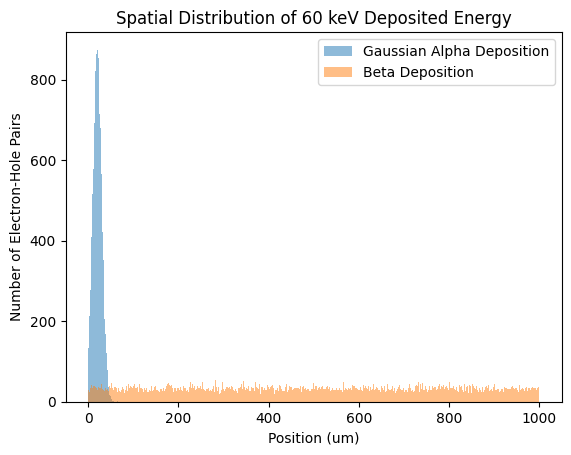

In [ ]:
### Set up for simulation, as well as creation of the electron and hole depositions ###

timestep = 0.001e-9
time = np.arange(0, 200e-9, timestep)
ns_time = time * 1e9
xn=xi
energy_deposited = 60 #keV 
num_pairs = energy_deposited / PAIR_CREATION_E
x_inits_alpha = generate_gauss_deposition(xn, 0.001, PAIR_CREATION_E*num_pairs)
x_inits_beta = generate_beta_deposition(PAIR_CREATION_E*num_pairs)
x_inits_alpha_um = x_inits_alpha * 1e4
print(num_pairs)

plt.hist(x_inits_alpha_um, bins=50, alpha=0.5, label='Gaussian Alpha Deposition')
plt.hist(x_inits_beta*1e4, bins=500, alpha=0.5, label='Beta Deposition')
plt.xlabel('Position (um)')
plt.ylabel('Number of Electron-Hole Pairs')
plt.title(f'Spatial Distribution of {energy_deposited} keV Deposited Energy')
plt.legend()

In [6]:
electron_array, hole_array = generate_arrays(timestep, xv, xg)

In [ ]:
### CURRENT AND CHARGE SIMULATION RESULTS with DIFFUSION ###

inualpha_diff, qnualpha_diff, inualpha_diff_e, inualpha_diff_h = simulate_event(x_inits_alpha, time, timestep, electron_array, hole_array)
inubeta_diff, qnubeta_diff, inubeta_diff_e, inubeta_diff_h = simulate_event(x_inits_beta, time, timestep, electron_array, hole_array)

In [ ]:
### CURRENT AND CHARGE SIMULATION RESULTS without DIFFUSION ###

inualpha, qnualpha, inualpha_e, inualpha_h = simulate_event(x_inits_alpha, time, timestep, electron_array, hole_array, diff=False)
inubeta, qnubeta, inubeta_e, inubeta_h = simulate_event(x_inits_beta, time, timestep, electron_array, hole_array, diff=False)

Text(0, 0.5, 'Collected Charge (fC)')

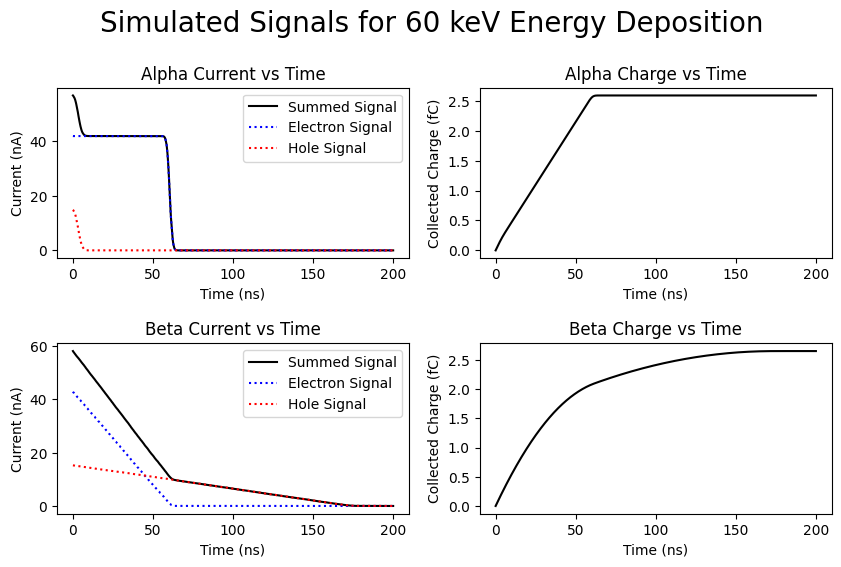

In [ ]:
### MAKING PLOTS ###


fig, ax = plt.subplots(2, 2, figsize=(10, 6))
fig.suptitle(f'Simulated Signals for {energy_deposited} keV Energy Deposition', y=0.95, fontsize=20)  # Adjust the y position of the supertitle

# Adjust the spacing between subplots
fig.subplots_adjust(hspace=0.5, top=0.82)  # Increase hspace for more space between rows, adjust top for less space above the first row

# First row
ax[0][0].plot(ns_time, inualpha_diff, label='Summed Signal', color='black', linestyle='-')
ax[0][0].plot(ns_time, inualpha_diff_e, label='Electron Signal', color='blue', linestyle=':')
ax[0][0].plot(ns_time, inualpha_diff_h, label='Hole Signal', color='red', linestyle=':')
ax[0][0].set_title('Alpha Current vs Time')
ax[0][0].set_xlabel('Time (ns)')
ax[0][0].set_ylabel('Current (nA)')
ax[0][0].legend()

ax[0][1].plot(ns_time, qnualpha_diff, label='Total Charge Collected Signal', color='black', linestyle='-')
ax[0][1].set_title('Alpha Charge vs Time')
ax[0][1].set_xlabel('Time (ns)')
ax[0][1].set_ylabel('Collected Charge (fC)')
#ax[0][1].legend()

# Second row
ax[1][0].plot(ns_time, inubeta_diff, label='Summed Signal', color='black', linestyle='-')
ax[1][0].plot(ns_time, inubeta_diff_e, label='Electron Signal', color='blue', linestyle=':')
ax[1][0].plot(ns_time, inubeta_diff_h, label='Hole Signal', color='red', linestyle=':')
ax[1][0].set_title('Beta Current vs Time')
ax[1][0].set_xlabel('Time (ns)')
ax[1][0].set_ylabel('Current (nA)')
ax[1][0].legend()


ax[1][1].plot(ns_time, qnubeta_diff, label='Total Charge Collected Signal', color='black', linestyle='-')
ax[1][1].set_title('Beta Charge vs Time')
ax[1][1].set_xlabel('Time (ns)')
ax[1][1].set_ylabel('Collected Charge (fC)')
#ax[1][1].legend()

'\nmax_int_a = q_int_a[-1]\nmax_int_b = q_int_b[-1]\nmax_q_a = qnualpha[-1]\nmax_q_b = qnubeta[-1]\n\nnorm_a = max_int_a / max_q_a\nnorm_b = max_int_b / max_q_b\n\nax[2][0].set_ylim(0, 0.1)\nax[2][0].set_xlim(0, 0.1)\nax[2][1].set_ylim(0, 0.1)\nax[2][1].set_xlim(0, 0.1)\n\nax[1][0].set_ylim(0, 0.1/norm_a)\nax[1][0].set_xlim(0, 0.1)\nax[1][1].set_ylim(0, 0.1/norm_b)\nax[1][1].set_xlim(0, 0.1)\n\nprint(qnualpha[:5]*norm_a, qnubeta[0:5]*norm_b)\nprint(q_int_a[:5], q_int_b[:5])\n'

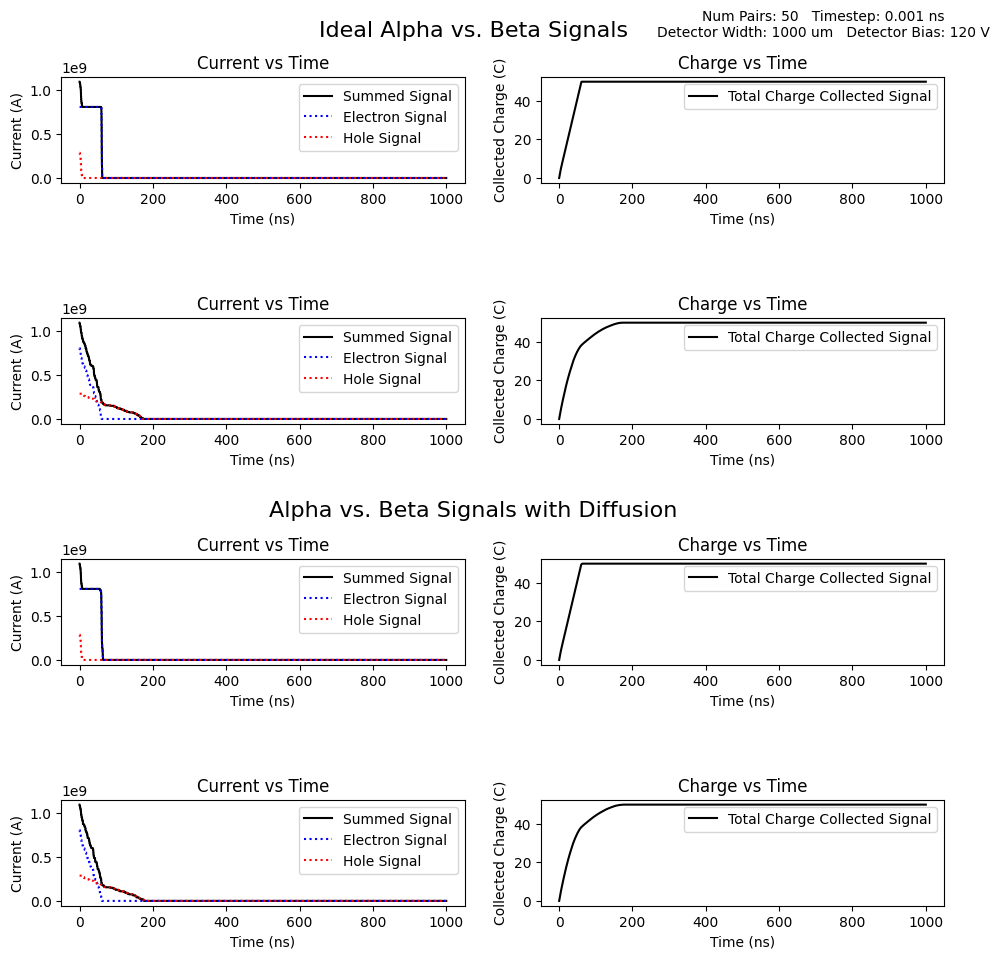

In [ ]:
### MAKING MORE PLOTS ###

'''fig, ax = plt.subplots(4, 2, figsize=(10, 10))

# First row
ax[0][0].plot(ns_time, inualpha, label='Summed Signal', color='black', linestyle='-')
ax[0][0].plot(ns_time, inualpha_e, label='Electron Signal', color='blue', linestyle=':')
ax[0][0].plot(ns_time, inualpha_h, label='Hole Signal', color='red', linestyle=':')
ax[0][0].set_title('Current vs Time')
ax[0][0].set_xlabel('Time (ns)')
ax[0][0].set_ylabel('Current (A)')
ax[0][0].legend()

ax[0][1].plot(ns_time, qnualpha, label='Total Charge Collected Signal', color='black', linestyle='-')
ax[0][1].set_title('Charge vs Time')
ax[0][1].set_xlabel('Time (ns)')
ax[0][1].set_ylabel('Collected Charge (C)')
ax[0][1].legend()

# Second row
ax[1][0].plot(ns_time, inubeta, label='Summed Signal', color='black', linestyle='-')
ax[1][0].plot(ns_time, inubeta_e, label='Electron Signal', color='blue', linestyle=':')
ax[1][0].plot(ns_time, inubeta_h, label='Hole Signal', color='red', linestyle=':')
ax[1][0].set_title('Current vs Time')
ax[1][0].set_xlabel('Time (ns)')
ax[1][0].set_ylabel('Current (A)')
ax[1][0].legend()

ax[1][1].plot(ns_time, qnubeta, label='Total Charge Collected Signal', color='black', linestyle='-')
ax[1][1].set_title('Charge vs Time')
ax[1][1].set_xlabel('Time (ns)')
ax[1][1].set_ylabel('Collected Charge (C)')
ax[1][1].legend()

# Third row
ax[2][0].plot(ns_time, inualpha_diff, label='Summed Signal', color='black', linestyle='-')
ax[2][0].plot(ns_time, inualpha_diff_e, label='Electron Signal', color='blue', linestyle=':')
ax[2][0].plot(ns_time, inualpha_diff_h, label='Hole Signal', color='red', linestyle=':')
ax[2][0].set_title('Current vs Time')
ax[2][0].set_xlabel('Time (ns)')
ax[2][0].set_ylabel('Current (A)')
ax[2][0].legend()

ax[2][1].plot(ns_time, qnualpha_diff, label='Total Charge Collected Signal', color='black', linestyle='-')
ax[2][1].set_title('Charge vs Time')
ax[2][1].set_xlabel('Time (ns)')
ax[2][1].set_ylabel('Collected Charge (C)')
ax[2][1].legend()

# Fourth row
ax[3][0].plot(ns_time, inubeta_diff, label='Summed Signal', color='black', linestyle='-')
ax[3][0].plot(ns_time, inubeta_diff_e, label='Electron Signal', color='blue', linestyle=':')
ax[3][0].plot(ns_time, inubeta_diff_h, label='Hole Signal', color='red', linestyle=':')
ax[3][0].set_title('Current vs Time')
ax[3][0].set_xlabel('Time (ns)')
ax[3][0].set_ylabel('Current (A)')
ax[3][0].legend()

ax[3][1].plot(ns_time, qnubeta_diff, label='Total Charge Collected Signal', color='black', linestyle='-')
ax[3][1].set_title('Charge vs Time')
ax[3][1].set_xlabel('Time (ns)')
ax[3][1].set_ylabel('Collected Charge (C)')
ax[3][1].legend()

# Adding titles for the top and bottom subplots
fig.text(0.5, 0.94, 'Ideal Alpha vs. Beta Signals', ha='center', fontsize=16)
fig.text(0.5, 0.46, 'Alpha vs. Beta Signals with Diffusion', ha='center', fontsize=16)
fig.text(0.85, 0.94, f'Num Pairs: {num_pairs}   Timestep: {timestep*1e9} ns\nDetector Width: {xv_um} um   Detector Bias: {BIAS} V', ha='center', fontsize=10)
plt.tight_layout(rect=[0, 0, 1, 0.95], pad=2.0, h_pad=5.0)  # Adjust padding as needed


'''
'''
max_int_a = q_int_a[-1]
max_int_b = q_int_b[-1]
max_q_a = qnualpha[-1]
max_q_b = qnubeta[-1]

norm_a = max_int_a / max_q_a
norm_b = max_int_b / max_q_b

ax[2][0].set_ylim(0, 0.1)
ax[2][0].set_xlim(0, 0.1)
ax[2][1].set_ylim(0, 0.1)
ax[2][1].set_xlim(0, 0.1)

ax[1][0].set_ylim(0, 0.1/norm_a)
ax[1][0].set_xlim(0, 0.1)
ax[1][1].set_ylim(0, 0.1/norm_b)
ax[1][1].set_xlim(0, 0.1)

print(qnualpha[:5]*norm_a, qnubeta[0:5]*norm_b)
print(q_int_a[:5], q_int_b[:5])
'''
